In [1]:
import time
import pandas as pd
import numpy as np

from lightgbm import LGBMRegressor
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import pickle
from sklearn.externals import joblib
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def train_save_model(model, X, y, filename):
    # fit model
    model.fit(X, y)
    
    # save model
    if isinstance(model, GridSearchCV):
        joblib.dump(model.best_estimator_, filename)
    else:
        joblib.dump(model, filename)

def load_eval_model(filename, X_train, X_val, y_train, y_val, val_set='Validation'):
    saved_model = joblib.load(filename)
    if isinstance(saved_model, RidgeCV):
        print(saved_model)
        print("best alpha: ", saved_model.alpha_)
    else:
        print(saved_model)

    # convert back to original scale
    train_preds = saved_model.predict(X_train)
    exp_train_preds = np.exp(train_preds)
    exp_y_train = np.exp(y_train)

    val_preds = saved_model.predict(X_val)
    exp_val_preds = np.exp(val_preds)
    exp_y_val = np.exp(y_val)

    print("----- Training scores -----")
    print("R2 on log scale: ", saved_model.score(X_train, y_train))
    print("RMSE on log scale: ", rmse(y_train, train_preds))
    print("RMSE on original $ scale: ", rmse(exp_y_train, exp_train_preds))

    print("----- {} scores -----".format(val_set))
    print("R2 on log scale: ", saved_model.score(X_val, y_val))
    print("RMSE on log scale: ", rmse(y_val, val_preds))
    print("RMSE on original $ scale: ", rmse(exp_y_val, exp_val_preds))

    # plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.regplot(y_val, val_preds, scatter_kws={'alpha':0.2}, ax=ax[0])
    ax[0].set_xlabel("True Value (log)")
    ax[0].set_ylabel("Predictions (log)")
    ax[0].set_title("Log $ Scale")

    sns.regplot(exp_y_val, exp_val_preds, scatter_kws={'alpha':0.2}, ax=ax[1])
    ax[1].set_xlabel("True Value")
    ax[1].set_ylabel("Predictions")
    ax[1].set_title("Original $ Scale")
    plt.tight_layout()

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.residplot(y_val, val_preds, scatter_kws={'alpha':0.2}, lowess=True, ax=ax[0])
    ax[0].set_ylabel("Residuals")
    ax[0].set_title("Residual Plot Log $ Scale")

    sns.residplot(exp_y_val, exp_val_preds, scatter_kws={'alpha':0.2}, lowess=True, ax=ax[1])
    ax[1].set_ylabel("Residuals")
    ax[1].set_title("Residual Plot Original $ Scale")
    plt.tight_layout()

def display_topics(model, feature_names, n_top_words):
    topic_top_words = []
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words_str = " ".join(top_words)
        print(top_words_str)
        topic_top_words.append(top_words_str)
    return topic_top_words

# Models - Regression

In [9]:
with open('data/features/TRAIN_SF.pkl', 'rb') as file:
    df = pickle.load(file)

with open('data/features/TEST_SF.pkl', 'rb') as file:
    df_test = pickle.load(file)

print('Train set: {}, Test set: {}'.format(df.shape, df_test.shape))

Train set: (103240, 36), Test set: (8549, 36)


In [10]:
zillow_features = ['AGE', 'LOTSIZE', 'GARAGE', 'LISTMONTH', 'LAT', 'LNG', 'BEDS', 'BATHS', 'SQFT']
rmk_features = [col for col in df.columns if 'lda_' in col or 'nmf_' in col]
features = zillow_features + rmk_features
print("Number of features - transformed remarks: ", len(features))

Number of features - transformed remarks:  29


In [11]:
df['LOTSIZE'] = df['LOTSIZE'].astype(str).apply(lambda x: x.replace(',', '')).astype(float)
df_test['LOTSIZE'] = df_test['LOTSIZE'].astype(str).apply(lambda x: x.replace(',', '')).astype(float)

In [12]:
wrong_garage_idx = df[df['GARAGE'].apply(lambda x: len(str(x))>5)]['GARAGE'].index
wrong_garage_idx

Int64Index([39764, 48169, 93392], dtype='int64')

In [13]:
df.drop(wrong_garage_idx, axis=0, inplace=True)

In [14]:
df['GARAGE'] = df['GARAGE'].astype(float)

In [15]:
test_wrong_garage_idx = df_test[df_test['GARAGE'].apply(lambda x: len(str(x))>5)]['GARAGE'].index
test_wrong_garage_idx

Int64Index([], dtype='int64')

In [16]:
df.fillna(-1, inplace=True)
df_test.fillna(-1, inplace=True)

### Test-Train Split, Response = 'SOLDPRICE'

In [17]:
response_col = 'SOLDPRICE'
test_size = 0.3
random_state = 9001

X_train, X_val, y_train, y_val = train_test_split(df[features], df[response_col], test_size=test_size, random_state=random_state)
X_test = df_test[features]
y_test = df_test[response_col]
print('X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
print('X_val.shape = {}, y_val.shape = {}'.format(X_val.shape, y_val.shape))
print('X_test.shape = {}, y_test.shape = {}'.format(X_test.shape, y_test.shape))

X_train.shape = (72265, 29), y_train.shape = (72265,)
X_val.shape = (30972, 29), y_val.shape = (30972,)
X_test.shape = (8549, 29), y_test.shape = (8549,)


In [18]:
col_names = X_train.columns.values

# normalize X_train, X_val, X_test
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=col_names)
X_val = pd.DataFrame(scaler.transform(X_val), columns=col_names)
X_test = pd.DataFrame(scaler.transform(X_test), columns=col_names)

# take log of responses
y_train = np.log(y_train)
y_val = np.log(y_val)
y_test = np.log(y_test)

### Train models

Ridge model: 
RidgeCV(alphas=(0.5, 1, 1.5), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)
best alpha:  1.0
----- Training scores -----
R2 on log scale:  0.6892359460573183
RMSE on log scale:  0.35186128175073356
RMSE on original $ scale:  623749.9786411405
----- Validation scores -----
R2 on log scale:  0.7006753893119408
RMSE on log scale:  0.3467948074994664
RMSE on original $ scale:  1011291.3097438945


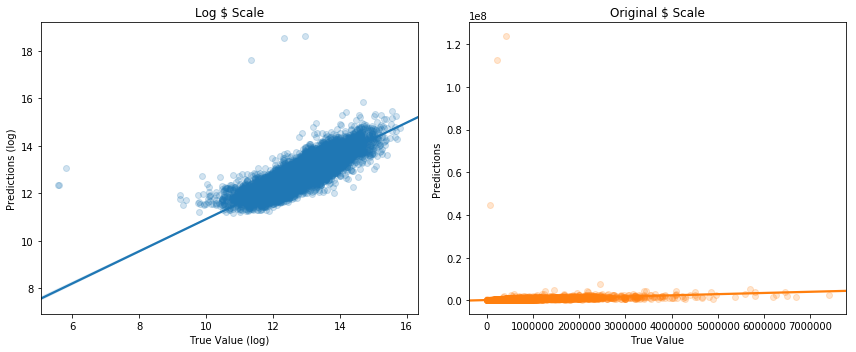

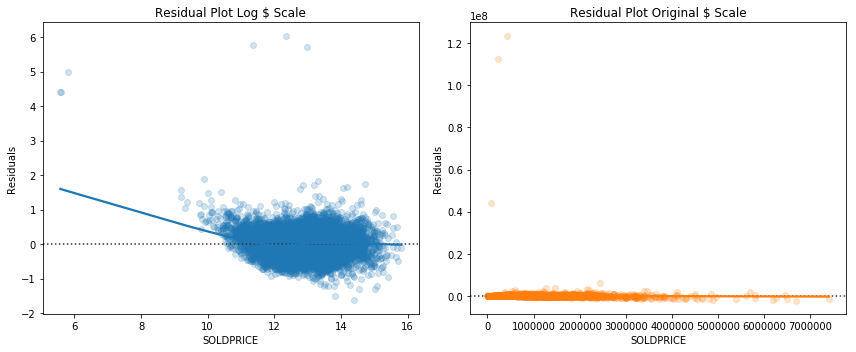

In [19]:
# Ridge
filename = 'models/soldprice/data_models/sf_price_ridge.pkl'

print("Ridge model: ")
# t0 = time.time()

# # train and save model
# model = RidgeCV(alphas=(0.5, 1, 1.5))
# train_save_model(model, X=X_train, y=y_train, filename=filename)
# print("training time: ", time.time()-t0)

# load savced model and evaluate model performance
load_eval_model(filename=filename, X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val)

RidgeCV(alphas=(0.5, 1, 1.5), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)
best alpha:  1.0
----- Training scores -----
R2 on log scale:  0.6892359460573183
RMSE on log scale:  0.35186128175073356
RMSE on original $ scale:  623749.9786411405
----- Test scores -----
R2 on log scale:  0.648245525067538
RMSE on log scale:  0.3752819111300431
RMSE on original $ scale:  1798529.2519334194


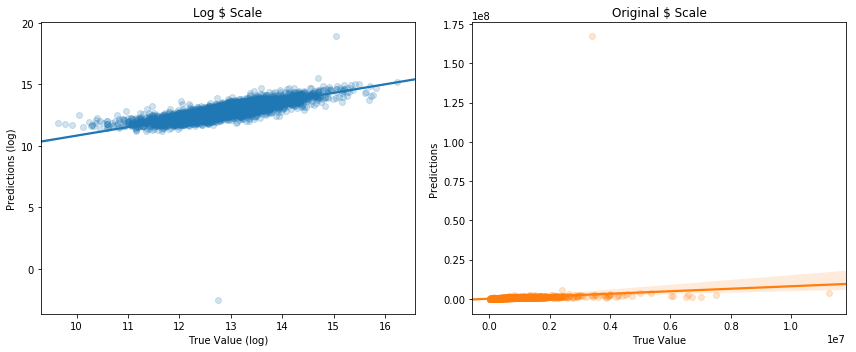

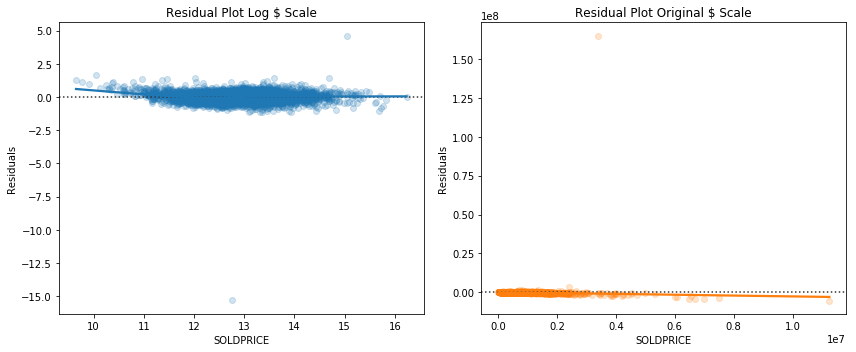

In [20]:
load_eval_model(filename=filename, X_train=X_train, X_val=X_test, y_train=y_train, y_val=y_test, val_set='Test')

XGBoost model: 
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_delta_step=0,
       max_depth=25, min_child_weight=1, missing=nan, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_seed=9001,
       random_state=0, reg_alpha=1, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
----- Training scores -----
R2 on log scale:  0.9605190335635223
RMSE on log scale:  0.1254151433241762
RMSE on original $ scale:  102505.05611039804
----- Validation scores -----
R2 on log scale:  0.9007615049318468
RMSE on log scale:  0.199683167866486
RMSE on original $ scale:  142614.0554417694


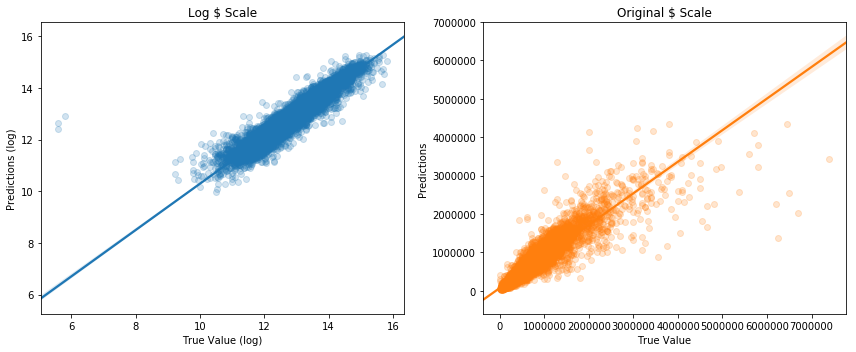

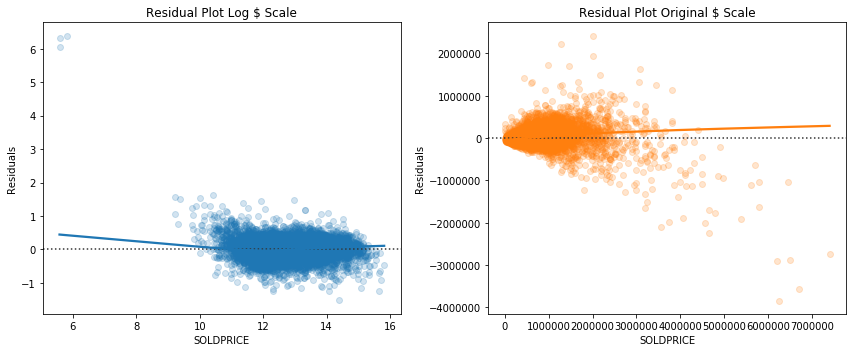

In [21]:
# XGBoost
filename = 'models/soldprice/data_models/sf_price_XGBoost.pkl'
params = {
    'max_depth':range(23,28,2),
    'gamma':[i/10.0 for i in range(1,5)],
    'reg_alpha':[1e-2, 0.1, 1]
}

print("XGBoost model: ")
# t0 = time.time()

# # model
# model = XGBRegressor(random_seed=9001)
# grid = GridSearchCV(model, params, verbose=1, n_jobs=-1)

# # train and save model
# train_save_model(grid, X=X_train, y=y_train, filename=filename)
# print("training time: ", time.time()-t0)

# load savced model and evaluate model performance
load_eval_model(filename=filename, X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_delta_step=0,
       max_depth=25, min_child_weight=1, missing=nan, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_seed=9001,
       random_state=0, reg_alpha=1, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
----- Training scores -----
R2 on log scale:  0.9605190335635223
RMSE on log scale:  0.1254151433241762
RMSE on original $ scale:  102505.05611039804
----- Test scores -----
R2 on log scale:  0.9018111833285527
RMSE on log scale:  0.1982753974457572
RMSE on original $ scale:  176382.26626481165


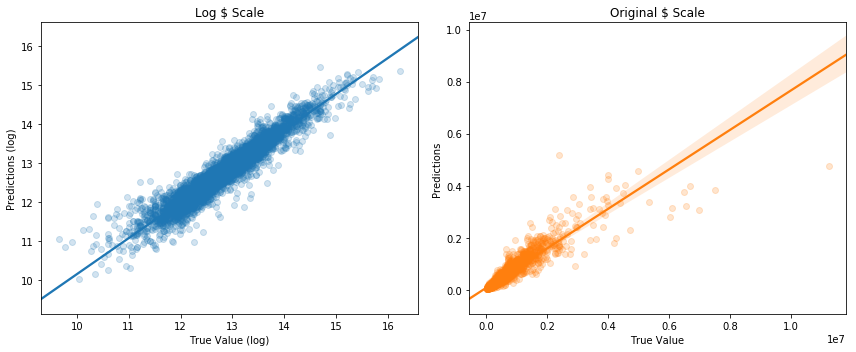

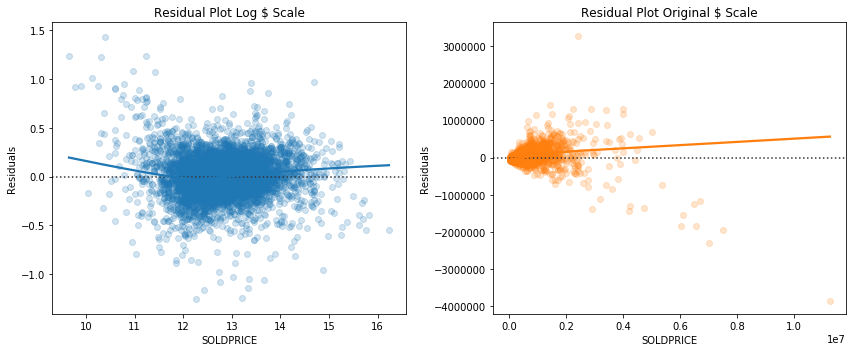

In [22]:
load_eval_model(filename=filename, X_train=X_train, X_val=X_test, y_train=y_train, y_val=y_test, val_set='Test')

Light GBM model: 
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=1024,
       n_jobs=-1, num_leaves=30, objective=None, random_state=9001,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)
----- Training scores -----
R2 on log scale:  0.9636050284762309
RMSE on log scale:  0.12041394451988519
RMSE on original $ scale:  76167.48604835635
----- Validation scores -----
R2 on log scale:  0.9038869357883188
RMSE on log scale:  0.196513587801344
RMSE on original $ scale:  137157.80727435532


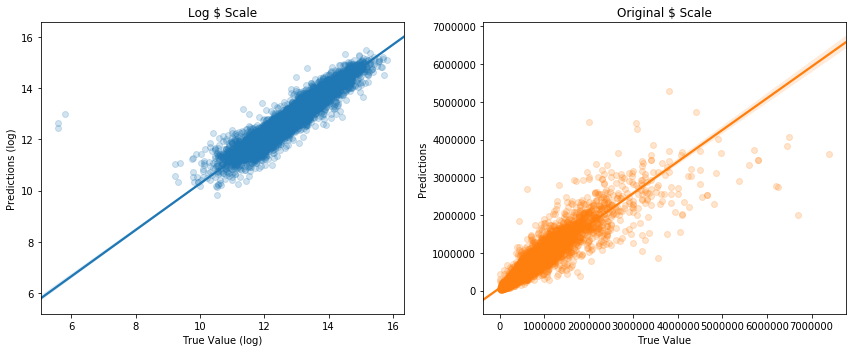

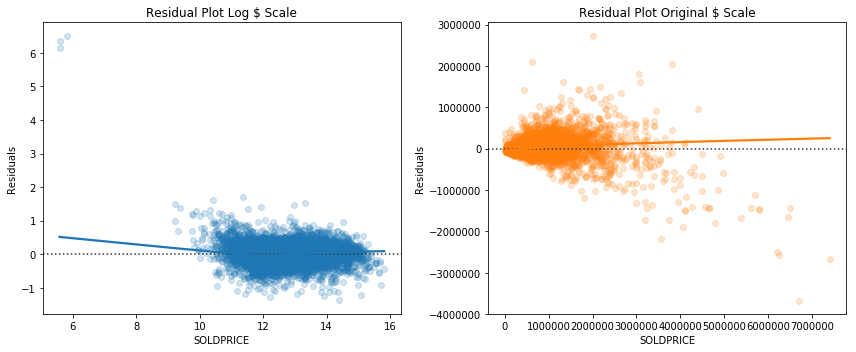

In [23]:
# Light GBM
filename = 'models/soldprice/data_models/sf_price_LGBM.pkl'
params = {'num_leaves': [30, 100, 200], 
          'max_depth':[-1, 16, 32, 64], 
          'learning_rate':[0.01, 0.1, 1], 
          'n_estimators':[256, 512, 1024]
         }

print("Light GBM model: ")
# t0 = time.time()

# # model
# model = model = LGBMRegressor(random_state=9001)
# grid = GridSearchCV(model, params, verbose=1, n_jobs=-1)

# # train and save model
# train_save_model(grid, X=X_train, y=y_train, filename=filename)
# print("training time: ", time.time()-t0)

# load savced model and evaluate model performance
load_eval_model(filename=filename, X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=1024,
       n_jobs=-1, num_leaves=30, objective=None, random_state=9001,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)
----- Training scores -----
R2 on log scale:  0.9636050284762309
RMSE on log scale:  0.12041394451988519
RMSE on original $ scale:  76167.48604835635
----- Test scores -----
R2 on log scale:  0.9036795724945212
RMSE on log scale:  0.19637989196487687
RMSE on original $ scale:  169406.25497806093


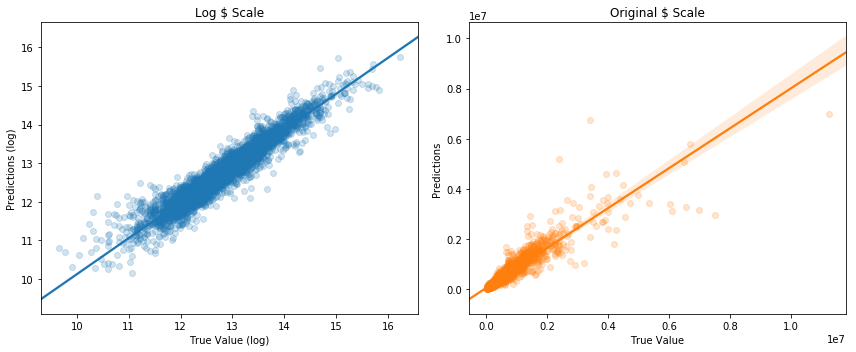

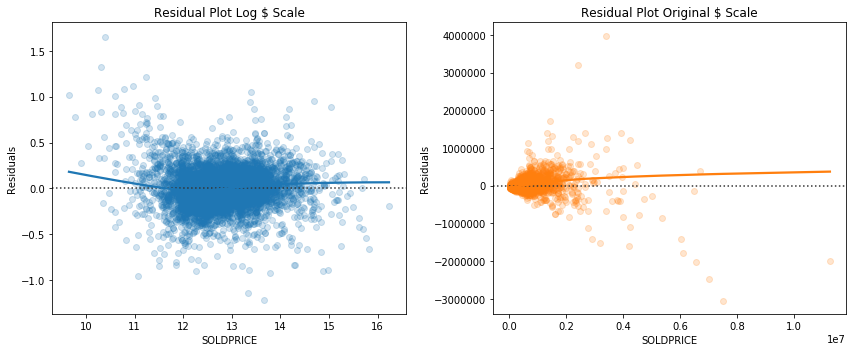

In [24]:
load_eval_model(filename=filename, X_train=X_train, X_val=X_test, y_train=y_train, y_val=y_test, val_set='Test')

### Test-Train Split, Response = 'DOM'

In [25]:
np.sum(df['DOM']<=1), np.sum(df_test['DOM']<=1)

(842, 87)

In [26]:
response_col = 'DOM'
test_size = 0.3
random_state = 9001

X_train, X_val, y_train, y_val = train_test_split(df[features], df[response_col], test_size=test_size, random_state=random_state)
X_test = df_test[features]
y_test = df_test[response_col]
print('X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
print('X_val.shape = {}, y_val.shape = {}'.format(X_val.shape, y_val.shape))
print('X_test.shape = {}, y_test.shape = {}'.format(X_test.shape, y_test.shape))

X_train.shape = (72265, 29), y_train.shape = (72265,)
X_val.shape = (30972, 29), y_val.shape = (30972,)
X_test.shape = (8549, 29), y_test.shape = (8549,)


In [27]:
col_names = X_train.columns.values

# normalize X_train and X_val
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=col_names)
X_val = pd.DataFrame(scaler.transform(X_val), columns=col_names)
X_test = pd.DataFrame(scaler.transform(X_test), columns=col_names)

# take log of responses
y_train = np.log(np.log(y_train+5))
y_val = np.log(np.log(y_val+5))
y_test = np.log(np.log(y_test+5))

Ridge model: 
RidgeCV(alphas=(1, 1.5, 2, 2.5, 3), cv=None, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)
best alpha:  1.5
----- Training scores -----
R2 on log scale:  0.07586583707600258
RMSE on log scale:  0.24444797717652847
RMSE on original $ scale:  0.916537350219272
----- Validation scores -----
R2 on log scale:  0.08503142837594768
RMSE on log scale:  0.2425800391977215
RMSE on original $ scale:  0.9163915245584803


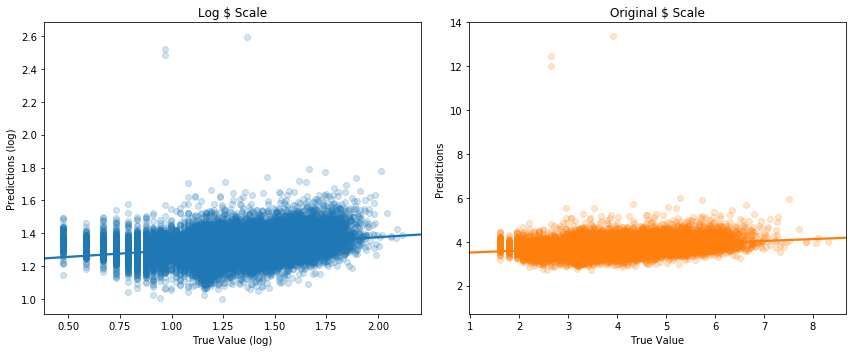

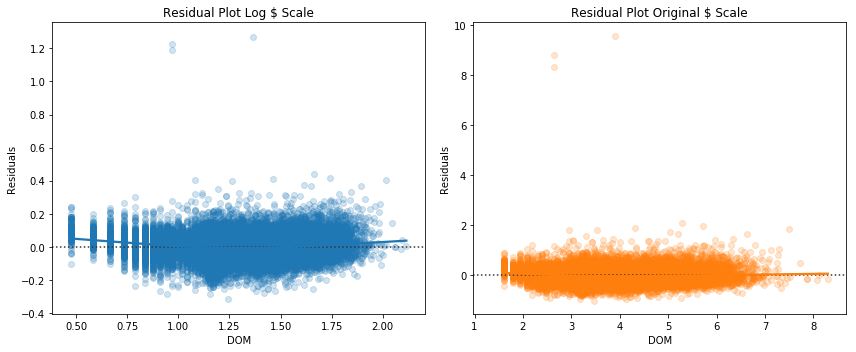

In [28]:
# Ridge
filename = 'models/dom/data_models/sf_dom_ridge.pkl'

print("Ridge model: ")
# t0 = time.time()

# # train and save model
# model = RidgeCV(alphas=(1, 1.5, 2, 2.5, 3))
# train_save_model(model, X=X_train, y=y_train, filename=filename)
# print("training time: ", time.time()-t0)

# load savced model and evaluate model performance
load_eval_model(filename=filename, X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val)

RidgeCV(alphas=(1, 1.5, 2, 2.5, 3), cv=None, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)
best alpha:  1.5
----- Training scores -----
R2 on log scale:  0.07586583707600258
RMSE on log scale:  0.24444797717652847
RMSE on original $ scale:  0.916537350219272
----- Test scores -----
R2 on log scale:  0.09238418808367799
RMSE on log scale:  0.23989634176012956
RMSE on original $ scale:  0.9049297006691644


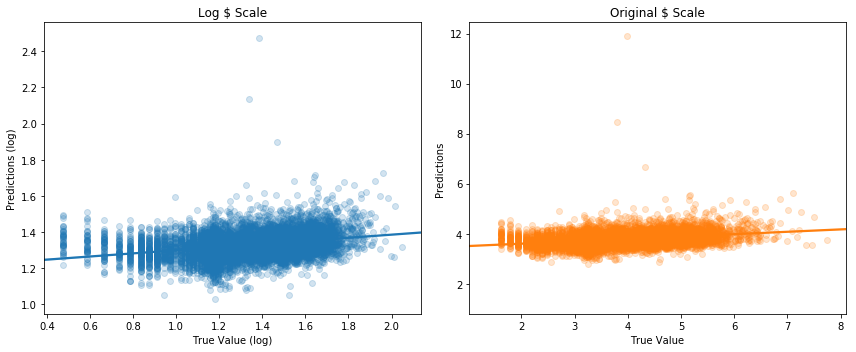

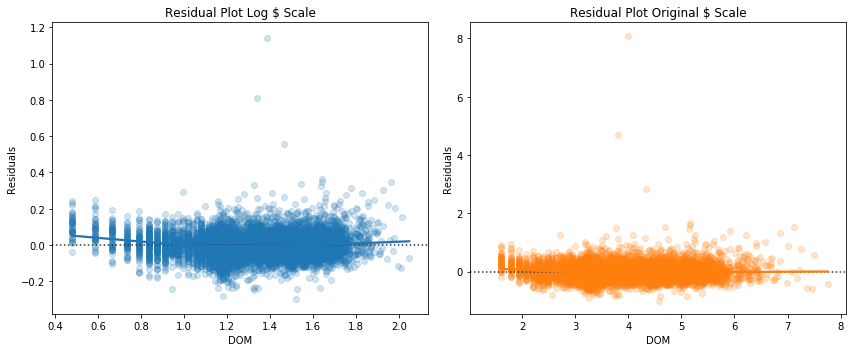

In [29]:
load_eval_model(filename=filename, X_train=X_train, X_val=X_test, y_train=y_train, y_val=y_test, val_set='Test')

XGBoost model: 
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_delta_step=0,
       max_depth=23, min_child_weight=1, missing=nan, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_seed=9001,
       random_state=0, reg_alpha=10, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
----- Training scores -----
R2 on log scale:  0.2703386450602414
RMSE on log scale:  0.21720989607011318
RMSE on original $ scale:  0.8129072383892747
----- Validation scores -----
R2 on log scale:  0.16193101620806483
RMSE on log scale:  0.23216238552407975
RMSE on original $ scale:  0.8713959177945256


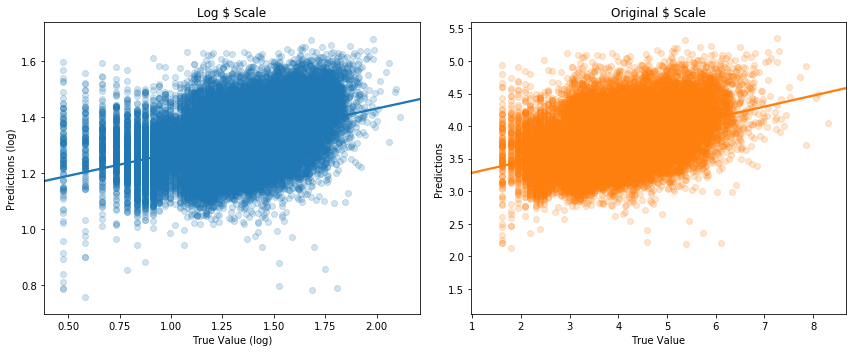

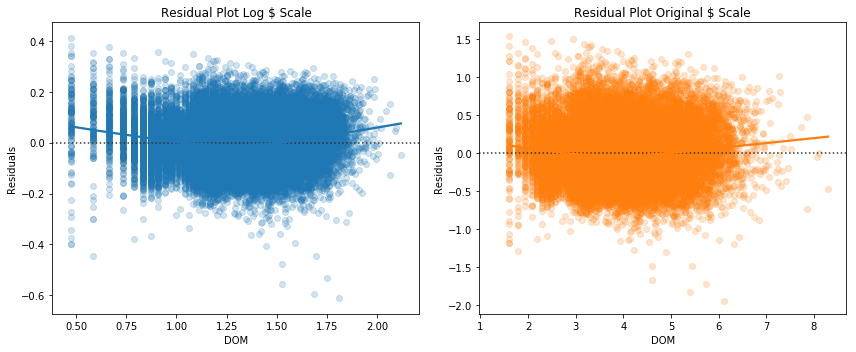

In [30]:
# XGBoost
filename = 'models/dom/data_models/sf_dom_XGBoost.pkl'
params = {
    'max_depth':range(21,28,2),
    'gamma':[i/10.0 for i in range(1,5)],
    'reg_alpha':[0.1, 1, 10, 100]
}

print("XGBoost model: ")
# t0 = time.time()

# # model
# model = XGBRegressor(random_seed=9001)
# grid = GridSearchCV(model, params, verbose=1, n_jobs=-1)

# # train and save model
# train_save_model(grid, X=X_train, y=y_train, filename=filename)
# print("training time: ", time.time()-t0)

# load savced model and evaluate model performance
load_eval_model(filename=filename, X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_delta_step=0,
       max_depth=23, min_child_weight=1, missing=nan, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_seed=9001,
       random_state=0, reg_alpha=10, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
----- Training scores -----
R2 on log scale:  0.2703386450602414
RMSE on log scale:  0.21720989607011318
RMSE on original $ scale:  0.8129072383892747
----- Test scores -----
R2 on log scale:  0.10208591362224118
RMSE on log scale:  0.23861074191813253
RMSE on original $ scale:  0.893827629762139


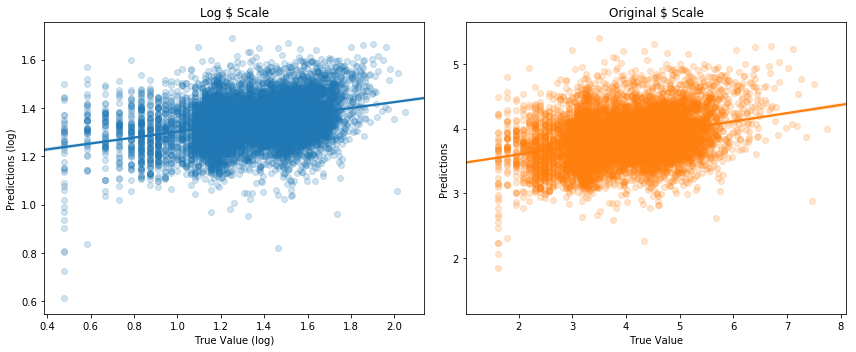

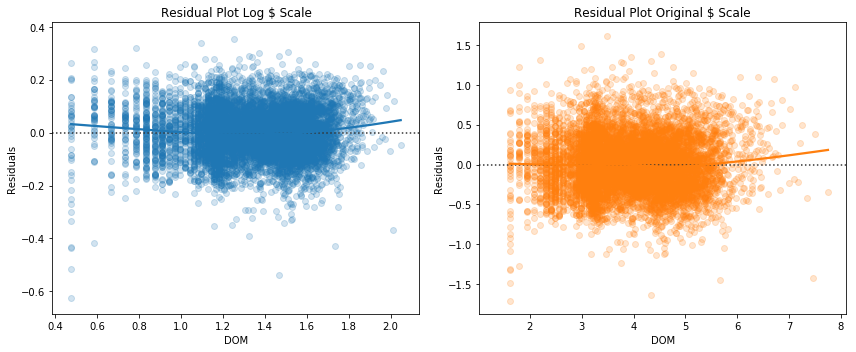

In [31]:
load_eval_model(filename=filename, X_train=X_train, X_val=X_test, y_train=y_train, y_val=y_test, val_set='Test')

Light GBM model: 
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.01, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=1024,
       n_jobs=-1, num_leaves=100, objective=None, random_state=9001,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)
----- Training scores -----
R2 on log scale:  0.35106949441621305
RMSE on log scale:  0.20484153911927921
RMSE on original $ scale:  0.7648644332698991
----- Validation scores -----
R2 on log scale:  0.16602797639405753
RMSE on log scale:  0.23159421907706676
RMSE on original $ scale:  0.8690311606704797


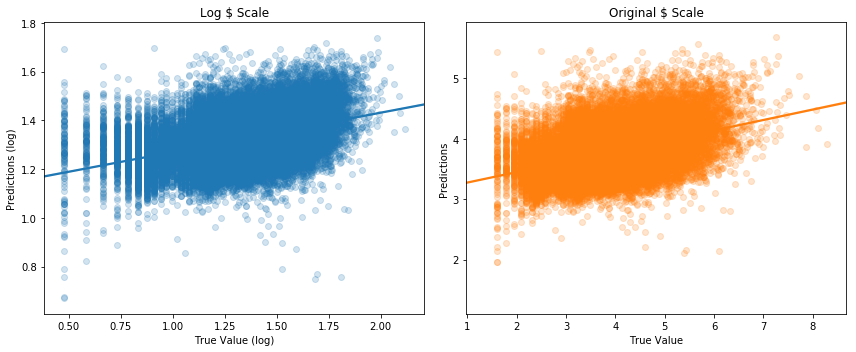

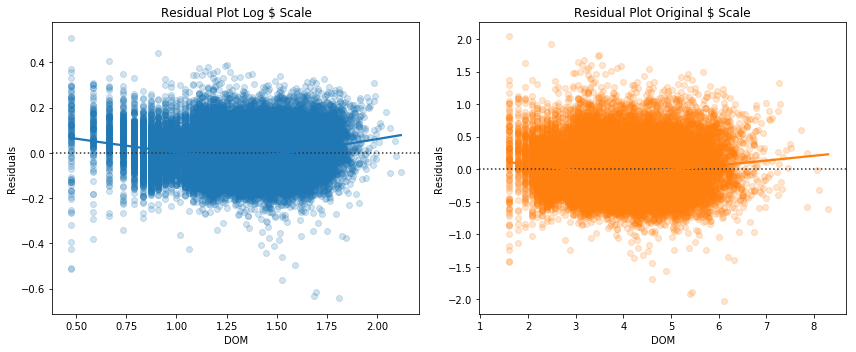

In [32]:
# Light GBM
filename = 'models/dom/data_models/sf_dom_LGBM.pkl'
params = {'num_leaves': [30, 100, 200], 
          'max_depth':[-1, 16, 32, 64], 
          'learning_rate':[1e-4, 1e-3, 0.01, 0.1], 
          'n_estimators':[256, 512, 1024]
         }

print("Light GBM model: ")
# t0 = time.time()

# # model
# model = model = LGBMRegressor(random_state=9001)
# grid = GridSearchCV(model, params, verbose=1, n_jobs=-1)

# # train and save model
# train_save_model(grid, X=X_train, y=y_train, filename=filename)
# print("training time: ", time.time()-t0)

# load savced model and evaluate model performance
load_eval_model(filename=filename, X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.01, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=1024,
       n_jobs=-1, num_leaves=100, objective=None, random_state=9001,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)
----- Training scores -----
R2 on log scale:  0.35106949441621305
RMSE on log scale:  0.20484153911927921
RMSE on original $ scale:  0.7648644332698991
----- Test scores -----
R2 on log scale:  0.09829274523441489
RMSE on log scale:  0.23911420704873923
RMSE on original $ scale:  0.8958290875883307


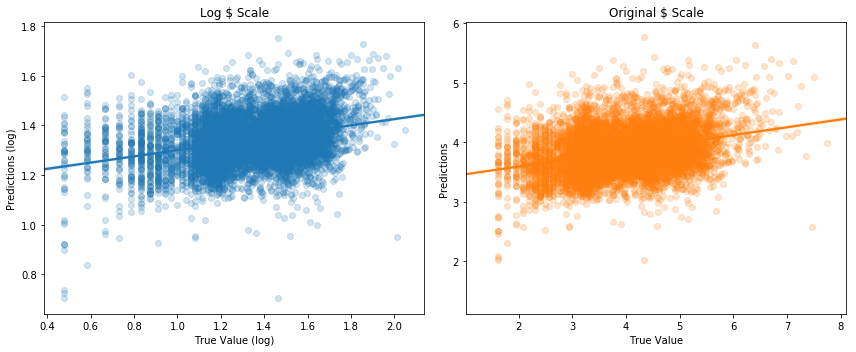

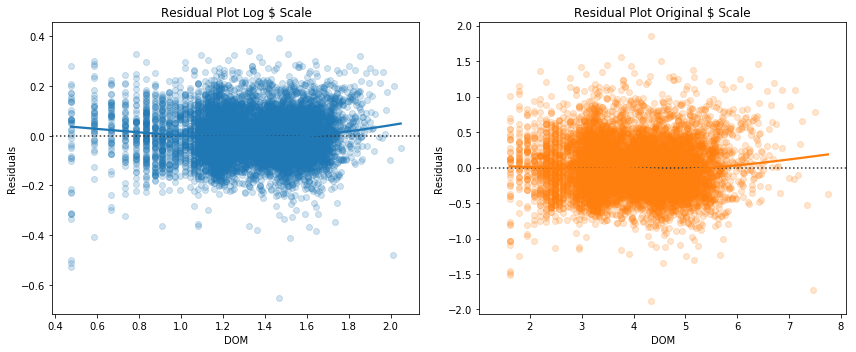

In [33]:
load_eval_model(filename=filename, X_train=X_train, X_val=X_test, y_train=y_train, y_val=y_test, val_set='Test')